# Homework2

## Introduction

- This notebook will apply the cleaned dataset from homework 1 and use it to create 3 different models to predict whether an applicant for credit will repay their credit within 2 years.
    - The value 0 indicates that an animal will have a positive outcome (adopted/returned to owner).
    - The value 1 indicates that an animal will have a negative outcome (death).
- Each model will be a supervised learning model and the output will be a binary classification. 
- For each applicant a number of features will be given (independent variables) and the target, risk performance (dependent variable), will be predicted.

This homework will be broken down into 5 main parts:
1. Review the dataset from homework one and decide on which features to use to build our model
2. Create a Linear Regression model and analyse
3. Create a Logistical Regression model and analyse
4. Create a Random Forest model and analyse
5. Try to optimize each model

We will begin by importing the packages needed for this assignment. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1) Data Understanding and Prep

The original dataset was cleaned in homework 1 and will now be imported as a starting point for this homework. There are some points to note before proceeding: 

- The cleaned dataset will be a starting point however, some additional cleaning steps will be performed before proceeding with homework2. 
- The data quality report for the cleaned dataset has been provided as a reference. 
- A summary of the data quality plan is seen below. 
- Based on the findings in homework1, four additional features were added. These are: 
    - 'SexKnown' which indicates whether the sex of an animal is known or not. 
    - 'CatOrDog' which indicates whether an animal is either a cat or a dog or not. 
    - 'AgeIntake_bins which grouped the ages of animals upon intake into four equal frequency bins.
    - 'SickOrInjured' which indicates whether an animal was sick/injured or not. 

## Insert data quality plan table here!

We will begin by importing the cleaned dataset from homework 1. 

In [2]:
# read in the cleaned csv
df = pd.read_csv("19205514_cleaned_new_features_added.csv")

#### Data integrity checks

Before going any further we will now perform some data integrity checks on the dataset which we have just imported. 

We will now begin by taking a look at the shape of the dataset and first five lines. 

In [3]:
#look at the shape of the dataset
df.shape

(1000, 23)

In [4]:
df.head(5)

,AnimalID,Name_Provided,DateTime_Intake,FoundLocation,IntakeType,IntakeCondition,AnimalType_Intake,SexuponIntake,AgeuponIntake,Breed_Intake,...,SexuponOutcome,AgeuponOutcome,binary_outcome,ColorOriginal,BreedOriginal,percent,SexKnown,CatOrDog,AgeIntake_bins,SickOrInjured
0,A687076,Yes,2014-08-30 17:55:00,Austin (TX),Stray,Normal,Cat,Intact Female,76,Mixed Breed,...,Spayed Female,82,0,Torbie,Domestic Shorthair Mix,0.109769,1,1,"(55.8, 92.0]",0
1,A685139,No,2014-08-03 11:23:00,Austin (TX),Stray,Other,Dog,Intact Female,92,Mixed Breed,...,Spayed Female,96,0,White/Black,Cavalier Span Mix,0.109769,1,1,"(55.8, 92.0]",0
2,A741039,Yes,2016-12-27 11:18:00,Austin (TX),Stray,Normal,Dog,Intact Male,366,Pure Breed,...,Intact Male,371,0,Black/White,Jack Russell Terrier,0.109769,1,1,"(365.0, 427.6]",0
3,A759166,Yes,2017-09-28 11:03:00,Austin (TX),Stray,Normal,Cat,Intact Male,62,Pure Breed,...,Neutered Male,99,0,Black,Domestic Shorthair,0.109769,1,1,"(55.8, 92.0]",0
4,A696479,Yes,2015-02-05 11:51:00,Travis (TX),Stray,Normal,Cat,Intact Male,365,Mixed Breed,...,Neutered Male,375,0,Black,Domestic Medium Hair Mix,0.109769,1,1,"(212.0, 365.0]",0


We can see that the feature 'percent' is still in the dataset. This was generating while implementing bar plots in homework1 and should not be part of the dataset. We will now drop this feature. 

In [5]:
#drop the feature 'percent'
df = df.drop("percent", 1)

Next, in order to conduct some integrity tests, we will look at the datatypes of our features after importing the csv. 

In [6]:
df.dtypes

AnimalID             object
Name_Provided        object
DateTime_Intake      object
FoundLocation        object
IntakeType           object
IntakeCondition      object
AnimalType_Intake    object
SexuponIntake        object
AgeuponIntake         int64
Breed_Intake         object
Color_Intake         object
DateTime_Outcome     object
DateofBirth          object
SexuponOutcome       object
AgeuponOutcome        int64
binary_outcome        int64
ColorOriginal        object
BreedOriginal        object
SexKnown              int64
CatOrDog              int64
AgeIntake_bins       object
SickOrInjured         int64
dtype: object

We can see that the datatpyes of some features have reverted back to type "object". We will now convert these features back to their appropriate types. 

Although the target feature *binary_outcome* is a categorical feature, will need to be an int when creating scatter plots in the next section, so we can leave it as it is at this stage. 

In [7]:
#convert all objects to categories
object_columns = df.select_dtypes(['object']).columns
for column in object_columns:
    df[column] = df[column].astype('category')

#convert animal ID to an object type
df['AnimalID'] = df['AnimalID'].astype('object')  

#convert the new features 'SexKnown','CatOrDog' and 'SickOrInjured' back to category type as this 
#is how they were implemented in homework1.
new_features = ['SexKnown','CatOrDog', 'SickOrInjured']
for column in new_features:
    df[column] = df[column].astype('category')
    
#convert all date features to datetime types
date_columns = ['DateTime_Intake', 'DateTime_Outcome', 'DateofBirth']
for column in date_columns: 
    df[column] = df[column].astype('datetime64[ns]')
    
#convert binary outcome to category type
# df['binary_outcome'] = df['binary_outcome'].astype('category') 

We are now ready to perform some data integrity tests. 

Test 1: Check if the 'DateTime_Outcome' is an earlier date than the 'DateTime_Intake' for any of the animals. This would imply that the animal stayed a negative length of time in the shelter which is impossible.

In [8]:
#create a dataframe containing the instances where date of outcome is less than date of intake
test_1 = df[['DateTime_Outcome','DateTime_Intake']][df['DateTime_Outcome'] < df['DateTime_Intake']]
#print out the number of instances failing the test
print("Number of rows failing the test: ", test_1.shape[0])
#view the instances
test_1.head()

Number of rows failing the test:  0


,DateTime_Outcome,DateTime_Intake


 - **Test 2:** Check if the *'DateTime_Intake'* for any animal is before their *'DateofBirth'*. This would imply that the animal entered the shelter before they were born which is impossible.

In [9]:
#create a dataframe containing the instances where date of intake is less than date of birth
test_2 = df[['DateTime_Intake','DateofBirth']][df['DateTime_Intake'] < df['DateofBirth']]
#print out the number of instances failing the test
print("Number of rows failing the test: ", test_2.shape[0])
#view the instances
test_2.head()

Number of rows failing the test:  0


,DateTime_Intake,DateofBirth


 - **Test 3:** Check if age of outcome is less than age of intake for any animal. This would imply that the animal decreased in age in the shelter which is impossible.

In [10]:
#create a dataframe containing the instances where date of intake is less than date of birth
test_3 = df[['AgeuponIntake','AgeuponOutcome']][df['AgeuponOutcome'] < df['AgeuponIntake']]
#print out the number of instances failing the test
print("Number of rows failing the test: ", test_3.shape[0])
#view the instances
test_3.head()

Number of rows failing the test:  0


,AgeuponIntake,AgeuponOutcome


We can see that there are no instances with failing logical integrity tests. We can now process with further cleaning steps. 

### Further cleaning steps

Upon reivew of homework 1, we will now perform some additional cleaning steps which need to be carried out before proceeding with the steps involved in homework 2. These are: 

- Breed_Intake high cardinality
- Colour_Intake high cardinality
- DateTime features
- Length of stay
- Remove AnimalID

**Breed_Intake high cardinality**:
Firstly, upon review of homework 1 I have decided that a more suitable grouping of the breed values could have been performed in order to overcome the issue of high cardinality. We have preserved the original values for *Breed_Intake* from homework1 in a feature called *BreedOriginal*. We will now perform a cleaning step in order to reduce the cardinality.

In [11]:
#look at the values 
df['BreedOriginal'].value_counts()[:20]

Domestic Shorthair Mix       259
Chihuahua Shorthair Mix       77
Labrador Retriever Mix        56
Pit Bull Mix                  52
Domestic Shorthair            43
Domestic Medium Hair Mix      26
German Shepherd Mix           20
Siamese Mix                   16
Boxer Mix                     15
Bat Mix                       15
Pit Bull                      13
Miniature Poodle Mix          11
Bat                           11
Domestic Longhair Mix         11
Border Collie Mix             11
Chihuahua Shorthair            9
German Shepherd                8
Australian Shepherd Mix        8
Australian Cattle Dog Mix      8
Rottweiler Mix                 7
Name: BreedOriginal, dtype: int64

We can see that there is a lot of overlap between with some breeds having the word "Mix" appended to the name. Our first step will be to remove the word "mix" and thus combine similar breeds. For example, 'Pit Bull' will be combined with 'Pit Bull Mix'.

In [12]:
df['BreedOriginal'] = df['BreedOriginal'].str.replace(r' Mix', '')

As dogs and cats are the most frequent animal type, we will now analyse the different breeds for these. Firstly, we will look at the breeds of dogs and will perform some cleaning in order to reduce the number of different breeds. We will group any dog breeds with a value count of 10 or less into one value called "Other Dog breeds". To do this, we first need to create a feature which represents the value counts of the different breeds. 

In [13]:
#create feature to represent value counts
df['Breed_Counts'] = df['BreedOriginal'].map(df['BreedOriginal'].value_counts())

In [14]:
#dog breeds with value count less than or equal to 10
dog_breed_low_value_counts = df[df["AnimalType_Intake"] == "Dog"][df['Breed_Counts']<=10]

In [15]:
#these are in group "Other dog breeds"
dog_breed_low_value_counts['BreedOriginal'] = 'Other Dog Breeds'

In [16]:
#update the df with this variable
df.update(dog_breed_low_value_counts)

We will now repeat the above steps for cats. As we did with Dogs, we will now group cat breeds with a value count less than or equal to 10 into a value called "Other Cat breeds".

In [17]:
#cat breeds with value count less than or equal to 10
cat_breed_low_value_counts = df[df["AnimalType_Intake"] == "Cat"][df['Breed_Counts']<=10]

In [18]:
#these are in group "Other dog breeds"
cat_breed_low_value_counts['BreedOriginal'] = 'Other Cat Breeds'

In [19]:
#update the df with this variable
df.update(cat_breed_low_value_counts)

In [20]:
#look at the breeds of cats
df['BreedOriginal'][df['AnimalType_Intake']!='Cat'][df['AnimalType_Intake']!='Dog'].value_counts()[:20]

Bat            26
Raccoon         7
Rabbit Sh       4
Guinea Pig      3
Chicken         3
Opossum         3
Skunk           2
Duck            1
Hamster         1
Snake           1
Ferret          1
Lop-Holland     1
Cold Water      1
Californian     1
Waxwing         1
Name: BreedOriginal, dtype: int64

We will now group all other animals into a value called "Other Animal Breeds". This is done because cats and dogs are the most frequent animal type and also because other animals are not divided into meaningful breeds in the same way that cats and dogs are. 

In [21]:
#create variable all animals other than cats and dogs
breeds_other_than_cat_or_dog = df[df['AnimalType_Intake']!='Cat'][df['AnimalType_Intake']!='Dog']

In [22]:
# group them into the one value
breeds_other_than_cat_or_dog['BreedOriginal'] = "Other Animal Breeds"

In [23]:
#update the df
df.update(breeds_other_than_cat_or_dog)

In [24]:
#view the final values 
df['BreedOriginal'].value_counts()

Domestic Shorthair      302
Other Dog Breeds        279
Chihuahua Shorthair      86
Pit Bull                 65
Labrador Retriever       63
Other Animal Breeds      56
Domestic Medium Hair     31
German Shepherd          28
Siamese                  18
Other Cat Breeds         18
Boxer                    16
Border Collie            13
Miniature Poodle         13
Domestic Longhair        12
Name: BreedOriginal, dtype: int64

Now that our we have reduced the cardinality of the breeds, we can replace *Breed_Intake with *BreedOriginal* as *Breed_Intake* is the feature we will work with throughout this assignment. We can remove the temporary features *BreedOriginal* and *Breed_Counts*. 

In [25]:
df['Breed_Intake']= df['BreedOriginal']

In [26]:
df = df.drop(['BreedOriginal', 'Breed_Counts'],1)

**Color_Intake high cardinality**:
Secondly, it was also found upon review of homework1 that the grouping I performed into 'Light' and 'Dark' could be improved. As with the breeds, we have gone back and created a temporary feature which preserves the orginial values within this feature. We will now use this temporary feature to perform some cleaning and reduce the high cardinality. 

In [27]:
#create a new dataframe in which we will split the color feature into two features
color_df = pd.DataFrame(columns=['firstcolor','secondcolor','ColorOriginal'])

In [28]:
#split the Color_Intake feature at the delimeter "/"
color_df[['firstcolor','secondcolor']] = df['ColorOriginal'].str.split("/",expand=True)

In [29]:
#check the unique values
color_df['firstcolor'].unique()

array(['Torbie', 'White', 'Black', 'Tan', 'Gray', 'Brown Brindle',
       'Tricolor', 'Brown', 'Brown Tabby', 'Red', 'Blue', 'Orange Tabby',
       'Gray Tabby', 'Chocolate', 'Tortie', 'Black Tabby', 'Calico',
       'Blue Tabby', 'Cream', 'Yellow', 'Sable', 'Silver Tabby',
       'Flame Point', 'Orange', 'Lynx Point', 'Blue Point', 'Cream Tabby',
       'Silver', 'Blue Merle', 'Fawn', 'Buff', 'Brown Tiger',
       'Seal Point', 'Blue Tick', 'Gold', 'Red Tick', 'Calico Point',
       'Tortie Point', 'Lilac Point', 'Red Merle', 'Pink', 'Brown Merle'],
      dtype=object)

In [30]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Tabby|Tortie|Torbie|Point|Calico|Merle|Tick')] = 'Mixed Pattern'

In [31]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Yellow|Cream|Gold|Fawn|Buff')] = 'Light Shades'

In [32]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Brown|Chocolate|Sable|Tan')] = 'Brown Shades'

In [33]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Silver|Gray')] = 'Grey'

In [34]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Mixed Pattern|White|Black|Light colours|Grey|Brown')==0] = 'Other'

In [35]:
df['ColorOriginal']=color_df['firstcolor']

In [36]:
df['Color_Intake']=df['ColorOriginal']

In [37]:
df = df.drop(['ColorOriginal'],1)

In [38]:
df.head(5)

,AnimalID,Name_Provided,DateTime_Intake,FoundLocation,IntakeType,IntakeCondition,AnimalType_Intake,SexuponIntake,AgeuponIntake,Breed_Intake,Color_Intake,DateTime_Outcome,DateofBirth,SexuponOutcome,AgeuponOutcome,binary_outcome,SexKnown,CatOrDog,AgeIntake_bins,SickOrInjured
0,A687076,Yes,2014-08-30 17:55:00,Austin (TX),Stray,Normal,Cat,Intact Female,76.0,Domestic Shorthair,Mixed Pattern,2014-09-05 14:33:00,2014-06-15,Spayed Female,82.0,0.0,1,1,"(55.8, 92.0]",0
1,A685139,No,2014-08-03 11:23:00,Austin (TX),Stray,Other,Dog,Intact Female,92.0,Other Dog Breeds,White,2014-08-07 18:09:00,2014-05-03,Spayed Female,96.0,0.0,1,1,"(55.8, 92.0]",0
2,A741039,Yes,2016-12-27 11:18:00,Austin (TX),Stray,Normal,Dog,Intact Male,366.0,Other Dog Breeds,Black,2017-01-01 15:27:00,2015-12-27,Intact Male,371.0,0.0,1,1,"(365.0, 427.6]",0
3,A759166,Yes,2017-09-28 11:03:00,Austin (TX),Stray,Normal,Cat,Intact Male,62.0,Domestic Shorthair,Black,2017-11-04 18:11:00,2017-07-28,Neutered Male,99.0,0.0,1,1,"(55.8, 92.0]",0
4,A696479,Yes,2015-02-05 11:51:00,Travis (TX),Stray,Normal,Cat,Intact Male,365.0,Domestic Medium Hair,Black,2015-02-15 11:39:00,2014-02-05,Neutered Male,375.0,0.0,1,1,"(212.0, 365.0]",0


Next, for the features *DateTime_Intake* and *DateTime_Outcome* some data integrity issues were dealt with in homework 1. Furthermore, in homework 1, some analysis was done of the month, day and hours of intake in a temporary dataframe, however, it was not deemed necessary at the time to split these features into categorical features representing the year, month and day. Before proceeding with predictive modelling we will now carry out this step. This step will make it easier to work with the high cardinality of the datetime features and it will convert them to a format which is easier to compare to the binary outcome and to work with for predictive modelling. 

We begin this step by converting the feature *DateTime_Intake* into year, month and day features. 

In [39]:
#extract the year, month and day from 'DateTime_Intake'
df['Intake_Year']=df['DateTime_Intake'].dt.year
df['Intake_Month']=df['DateTime_Intake'].dt.month
df['Intake_Day']=df['DateTime_Intake'].dt.day_name()

We will also look at the hour of intake as we believe this could be interesting. 

In [40]:
df['Intake_Hour']=df['DateTime_Intake'].dt.hour
df['Intake_Hour_bins']=pd.cut(df['Intake_Hour'],bins=[0,6,12,18,24], labels=['Early_Morning','Late_Morning','Afternoon','Evening/Night'])

In [41]:
df['Intake_Hour_bins'].value_counts()

Afternoon        579
Late_Morning     382
Evening/Night     27
Early_Morning      8
Name: Intake_Hour_bins, dtype: int64

We will now convert *DateTime_Outcome* into year, month and day features. 

In [42]:
#extract the year, month and day from 'DateTime_Outcome'
df['Outcome_Year']=df['DateTime_Outcome'].dt.year
df['Outcome_Month']=df['DateTime_Outcome'].dt.month
df['Outcome_Day']=df['DateTime_Outcome'].dt.day_name()
# df['Outcome_Hour']=df['DateTime_Outcome'].dt.hour

We will now convert these new features to type 'category'.

In [43]:
#convert new features to category type
new_date_features = ['Intake_Year','Intake_Month', 'Intake_Day', 'Intake_Hour', 'Intake_Hour_bins', 'Outcome_Year', 'Outcome_Month', 'Outcome_Day']
for column in new_date_features: 
    df[column] = df[column].astype('category')

#convert all objects to categories
object_columns = df.select_dtypes(['object']).columns
for column in object_columns:
    df[column] = df[column].astype('category')

In [44]:
df.dtypes

AnimalID                   category
Name_Provided              category
DateTime_Intake      datetime64[ns]
FoundLocation              category
IntakeType                 category
IntakeCondition            category
AnimalType_Intake          category
SexuponIntake              category
AgeuponIntake               float64
Breed_Intake               category
Color_Intake               category
DateTime_Outcome     datetime64[ns]
DateofBirth          datetime64[ns]
SexuponOutcome             category
AgeuponOutcome              float64
binary_outcome              float64
SexKnown                   category
CatOrDog                   category
AgeIntake_bins             category
SickOrInjured              category
Intake_Year                category
Intake_Month               category
Intake_Day                 category
Intake_Hour                category
Intake_Hour_bins           category
Outcome_Year               category
Outcome_Month              category
Outcome_Day                c

The features *DateTime_Intake* and *DateTime_Outcome* were of type datetime64. The new year, month and day features extracted from these have a much lower cardinality and are in a format that is much more useful for predictive modelling. 


Finally, in homework 1 we did indeed explore the length of stay of animals in the shelter when carrying out data integrity tests. However, we did not make a new feature to represent this information and investigate its relationship with the binary outcome. As a result, we will do that now by subtracting the date of intake from the date of outcome. 

In [45]:
#create new feature length of stay
df['LengthOfStay'] = (df['DateTime_Outcome'] - df['DateTime_Intake']).dt.days

We will plot this new feature against the binary outcome shortly.

We can now drop the original features *DateTime_Intake* and *DateTime_Outcome* as we have extracted all important information and no information will be lost. 

In [46]:
#drop the features 'DateTime_Intake' and'DateTime_Outcome'
df = df.drop('DateTime_Intake', 1)
df = df.drop('DateTime_Outcome', 1)

The next step in our further cleaning is to drop the feature 'AnimalID'as this is only needed for reference purposes and is not helpful in predictive modelling. 

In [47]:
#drop 'AnimalID'
df = df.drop('AnimalID', 1)

Missing values were dealt with in homework1. However, we will now check to ensure that there are currently no missing values in our dataset. 

In [48]:
df.isna().sum()

Name_Provided        0
FoundLocation        0
IntakeType           0
IntakeCondition      0
AnimalType_Intake    0
SexuponIntake        0
AgeuponIntake        0
Breed_Intake         0
Color_Intake         0
DateofBirth          0
SexuponOutcome       0
AgeuponOutcome       0
binary_outcome       0
SexKnown             0
CatOrDog             0
AgeIntake_bins       0
SickOrInjured        0
Intake_Year          0
Intake_Month         0
Intake_Day           0
Intake_Hour          0
Intake_Hour_bins     4
Outcome_Year         0
Outcome_Month        0
Outcome_Day          0
LengthOfStay         0
dtype: int64

We can see that there are no missing values. We will now check the datatypes again before proceeding with plots.

In [49]:
df.dtypes

Name_Provided              category
FoundLocation              category
IntakeType                 category
IntakeCondition            category
AnimalType_Intake          category
SexuponIntake              category
AgeuponIntake               float64
Breed_Intake               category
Color_Intake               category
DateofBirth          datetime64[ns]
SexuponOutcome             category
AgeuponOutcome              float64
binary_outcome              float64
SexKnown                   category
CatOrDog                   category
AgeIntake_bins             category
SickOrInjured              category
Intake_Year                category
Intake_Month               category
Intake_Day                 category
Intake_Hour                category
Intake_Hour_bins           category
Outcome_Year               category
Outcome_Month              category
Outcome_Day                category
LengthOfStay                  int64
dtype: object

We will now setup our categorical and continuous features. These will be needed for plotting and for the creation of dummies later. 

In [50]:
categorical_features = df.select_dtypes(['category']).columns
continuous_features = ['AgeuponIntake', 'AgeuponOutcome', 'LengthOfStay']
date_features = ['DateofBirth']

### (1.1) Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. 

Before proceeding with splitting the dataset we weill first take a look at the ratio of different levels of the target categorical feature. 

In [51]:
df['binary_outcome'].value_counts()

0.0    920
1.0     80
Name: binary_outcome, dtype: int64

Sklearn train_test_split randomly shuffles and samples the dataset as per the test size given as a parameter. This random sampling is often a good choice in order to avoid introducing bias. However, as explained in section 3.6.3 of the course text book 'Fundamentals of Machine Learning for Predictive Data Analytics', since only small proportion of the instances in our dataset are of class 1, there is a chance if we use random sampling these instances will be omitted or underrepresented. 

For this reason, we will use stratified sampling instead of random sampling. This will ensure that the relative frequencies of the two levels of our target feature *binary_outcome* are maintained in the sampled dataset. 

**The dataset will now be split into two separate datasets - 70% training and 30% test using stratified sampling**
- We set the target feature "y" to be "binary_outcome"
- We feature "x" to be all remaining features in the dataset. The feature "binary_outcome" will be excluded.

In [52]:
y = df.binary_outcome
# y = pd.DataFrame(df["binary_outcome"])
X = df.drop(["binary_outcome"],1)

We will now split the dataset. The parameter 'test-size' will determine the size of the training and test datasets. We will set this to 0.3 in order to split into 70% training and 30% test. The parameter 'random_state' sets a seed to the train_test_split random generator. We will set this parameter to 1 to ensure that the train/test split is the same each time this code is executed.  

In [53]:
# This code was provided in lab 7.
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1, stratify=y)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

print("\nTarget feature binary_outcome total dataset counts:\n\n", y.value_counts())
print("\nTraining data binary_outcome counts:\n", y_train.value_counts())
print("\nTest data binary_outcome counts:\n", y_test.value_counts())

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000

Target feature binary_outcome total dataset counts:

 0.0    920
1.0     80
Name: binary_outcome, dtype: int64

Training data binary_outcome counts:
 0.0    644
1.0     56
Name: binary_outcome, dtype: int64

Test data binary_outcome counts:
 0.0    276
1.0     24
Name: binary_outcome, dtype: int64


We can see from the output printed above that class 1 accounts for 8% of the instances in the full dataset and in the training and test splits. Thus, the train/test samples have a distribution representative of the full sample for class 0 and class 1 of the target feature *binary_outcome*. We are now ready to plot the features. 

#### (1.2) On the training set - For each continuous feature, plot its interaction with the target feature. Discuss what you observe from these plots. Choose a subset of continuous features you find promising (if any).

- All plots will be generated using on the training subset created above - X_train, y_train. The testing subset will be left aside.
- We will use the lists of categorical features, continuous features and date_time features created above. 

#### 1.2.1 Plot correlations between the continous features.

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

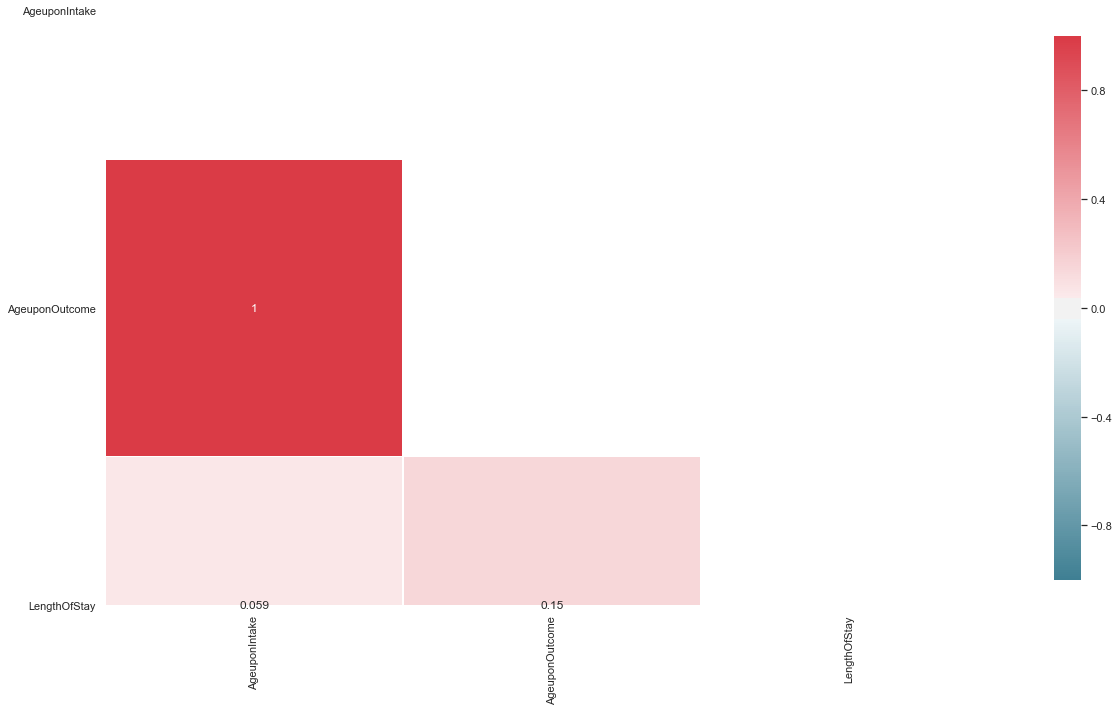

In [54]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

We can see the following in the above correlation matrix: 
-  *AgeUponIntake* and *AgeUponOutcome* have an extremely high correlation of 1. This is an expected and indicates that only one of these features would need to be kept. 
-  Both *AgeUponIntake* and *AgeUponOutcome* are very weakly correlated with length of stay, with values of 0.059 and 0.15, respectively. 

#### 1.2.2 Plot correlation between continous features and target feature. 

- We will now loop over both continuous features and plot them against the target *binary_outcome*. 
- We will discuss our findings from these plots and choose a subset (if any) of the feature(s) which seem promising. 
- As we left the target feature as type int64 earlier, we do not need to convert it now for these scatter plots. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


,binary_outcome
AgeuponIntake,0.059184
AgeuponOutcome,0.054104
LengthOfStay,-0.051748


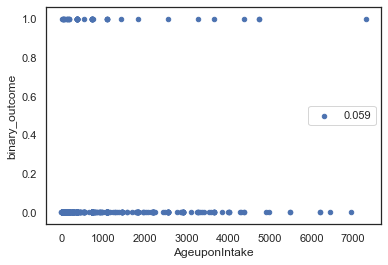

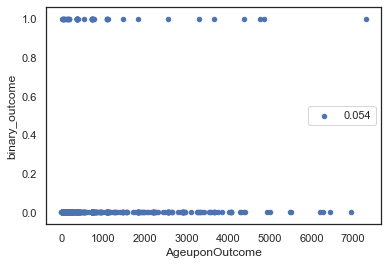

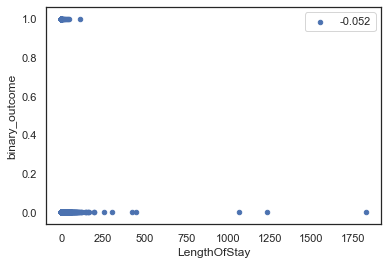

In [55]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_features]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['binary_outcome']).sort_values('binary_outcome', ascending=False)
corr_df

#### 1.2.2 Interpretation of the results

- We can see that there is no clearly defined correlation between either feature and the target feature.
- The result is surprising as it was expected that the age of an animal would have an effect on its outcome. 
- However, this result is perhaps explained by the large range of ages and the variety of animals which the ages represent. 
- The sorted correlation dataframes above the plots give an even clearer indication of the results. We can see that the correlation between *AgeUponIntake* and the target feature is 0.059 while the correlation between *AgeUponOutcome* and the target feature is 0.054.
- It must be noted however, that as described in section 3.6.1 of the FMLPD course textbook, continuous features that cover very different ranges should be normalised. As we are dealing with the ages of many different species of animals, normalisation would cause these two continous features to fall within a specified range while maintaining the relative differences between the values for the feature. In other words, adding a normalisation step would better represent the different between an old dog and an old racoon, for example. 
- At this stage in the assignment however, we are choosing the leave the ages at their absolute values. Later in the assignment we will have the option to implement normalisation and make a comparision.
- The correlation between *lengthOfStay* and the outcome is -0.052. This feature will be dropped as these results show that it is likely not an indicator of the binary outcome. 
- As a result, at this stage we will drop these two features as they do not look like good predictors of the target outcome. 

## TODO Investigating whether to normalise ages.........

In [56]:
# dict to hold correlation values 
# corr_dict = {}

# # plot pairwise interaction between all continuous features and target
# for column in X_train[X_train["AnimalType_Intake"]=="Cat"][continuous_features]:
#     # create temp df to merge column and target
#     df_temp = pd.concat([X_train[X_train["AnimalType_Intake"]=="Cat"][column], y_train], axis=1)
#     # store correlation in variable
#     correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
#     # plot the column and tartget feature
#     df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
#     # add correlation to dict
#     corr_dict[column] = correlation

# # dataframe holding sorted correlation values to aid in interpreting results
# corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['binary_outcome']).sort_values('binary_outcome', ascending=False)
# corr_df

For now we will label the two continuous features as ```low_correlation_continuous_features``` and will remove them after analysing the categorical features. 

In [57]:
low_correlation_continuous_features = ['AgeuponIntake', 'AgeuponOutcome', 'LengthOfStay']

#### 1.2.3 Plot interaction between categorical features and target feature.

- We will now plot a pairwise interaction between each categorical feature and the target feature. 
- We will discuss which features seem to be better at predicting the target feature and will choose a subset of features we find promising.
- As with the plots of continuous features above, only the training dataset will be used. 
- To create these plots we will work with the variable *categorical_features* created above. 
- We will begin by converting the target feature to a categorical type as this is required for these plots. 

In [58]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")


 Name_Provided
Index 	 Count
No 	 212
Yes 	 488

 FoundLocation
Index 	 Count
Austin (TX) 	 575
Travis (TX) 	 63
Other 	 5
Outside Jurisdiction 	 6
Manor (TX) 	 15
Pflugerville (TX) 	 13
Del Valle (TX) 	 23

 IntakeType
Index 	 Count
Stray 	 495
Owner Surrender 	 133
Public Assist 	 48
Wildlife 	 23
Euthanasia Request 	 1

 IntakeCondition
Index 	 Count
Normal 	 622
Injured 	 33
Sick 	 30
Other 	 1
Nursing 	 14

 AnimalType_Intake
Index 	 Count
Cat 	 269
Dog 	 393
Bat 	 17
Other 	 16
Bird 	 5

 SexuponIntake
Index 	 Count
Intact Female 	 219
Neutered Male 	 99
Intact Male 	 236
Spayed Female 	 86
Unknown 	 60

 Breed_Intake
Index 	 Count
Domestic Shorthair 	 217
Domestic Longhair 	 9
Pit Bull 	 49
Other Dog Breeds 	 187
Labrador Retriever 	 45
Other Animal Breeds 	 38
Border Collie 	 8
Miniature Poodle 	 10
Chihuahua Shorthair 	 60
Other Cat Breeds 	 12
Domestic Medium Hair 	 22
German Shepherd 	 22
Boxer 	 12
Siamese 	 9

 Color_Intake
Index 	 Count
Mixed Pattern 	 167
White 	 84
Bro

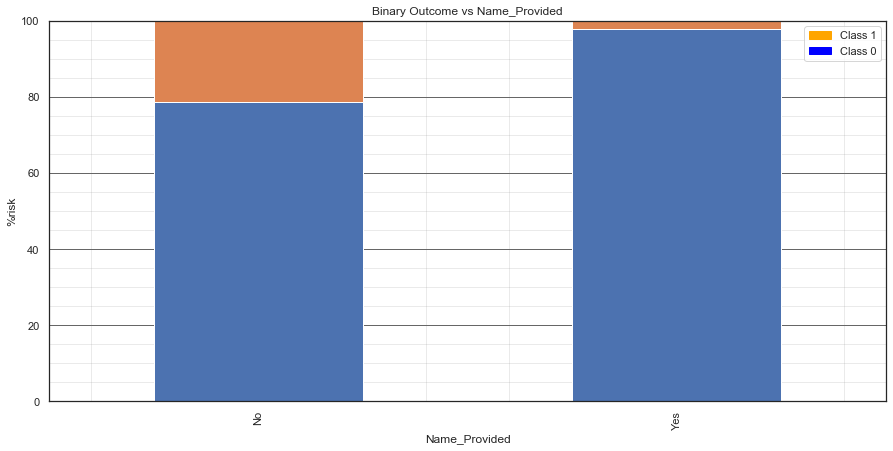

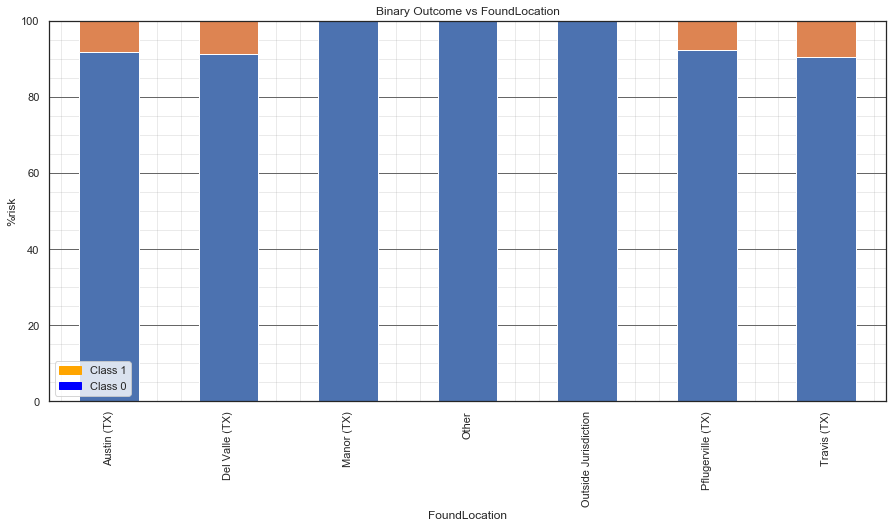

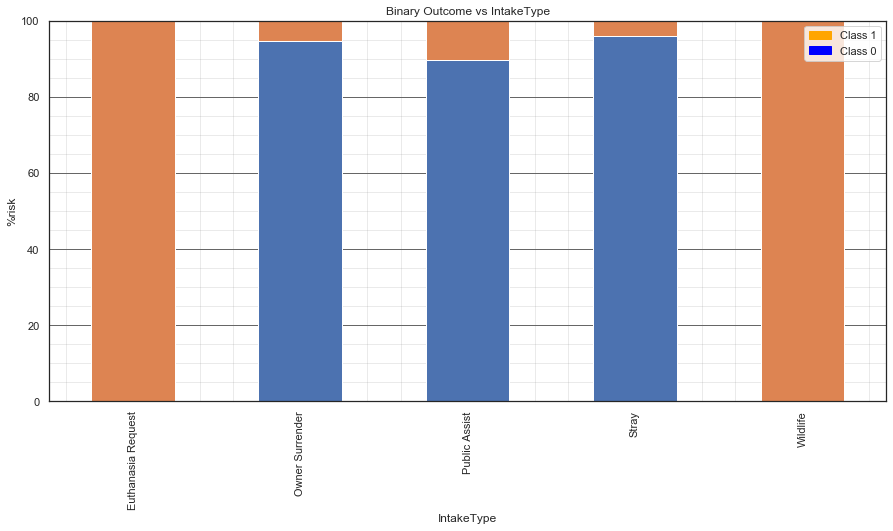

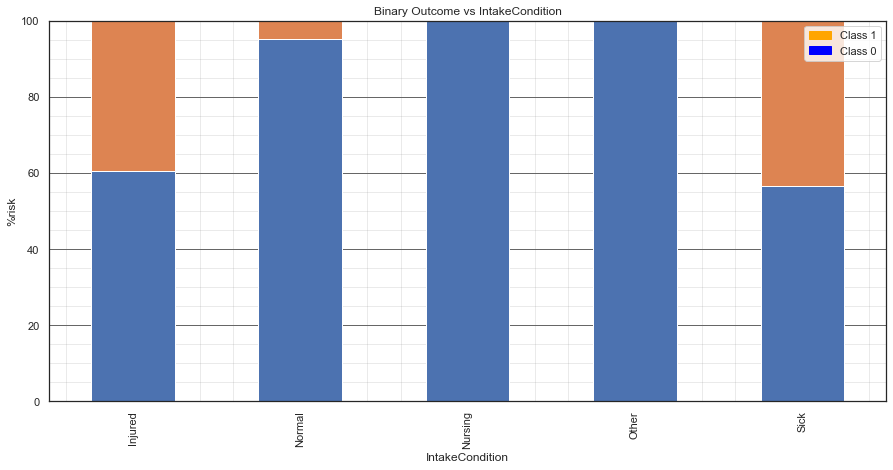

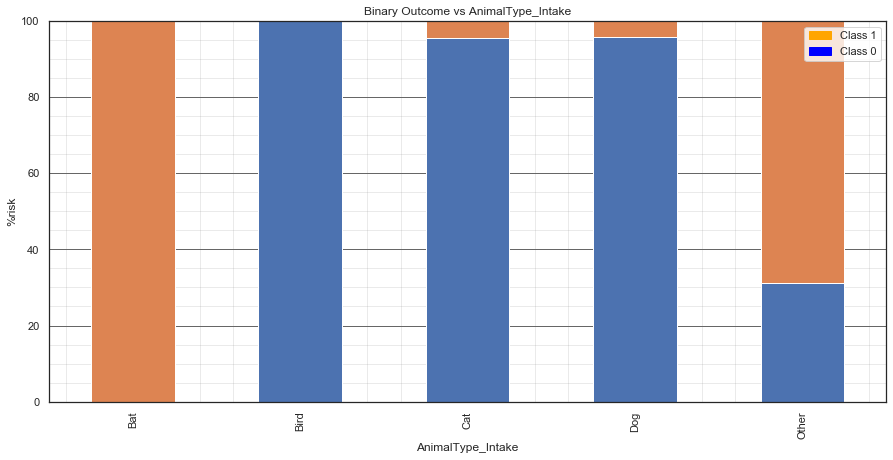

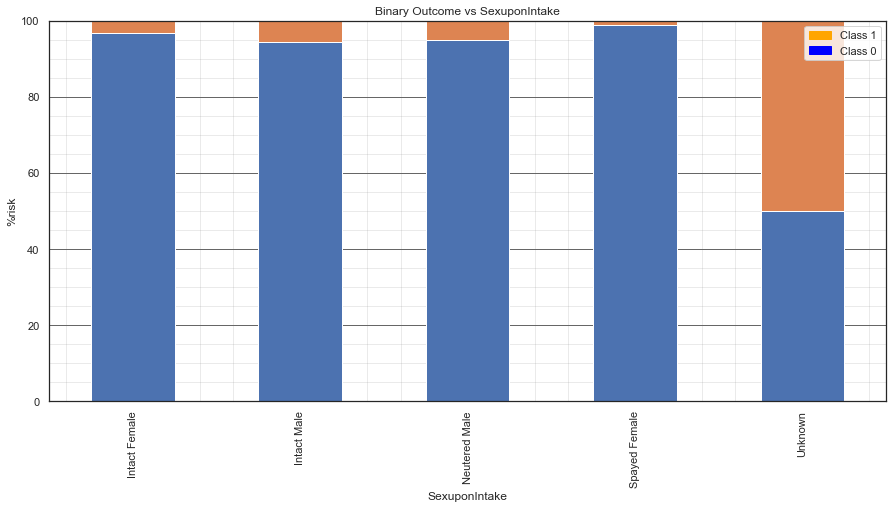

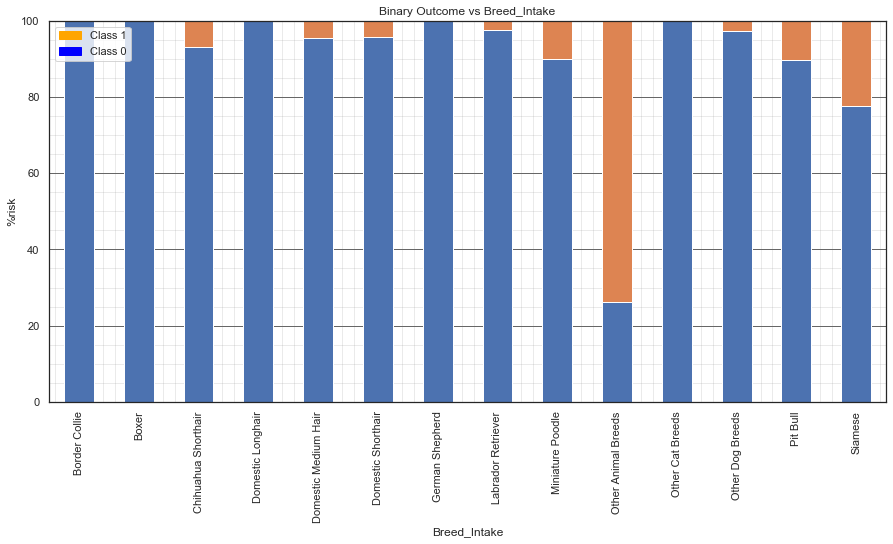

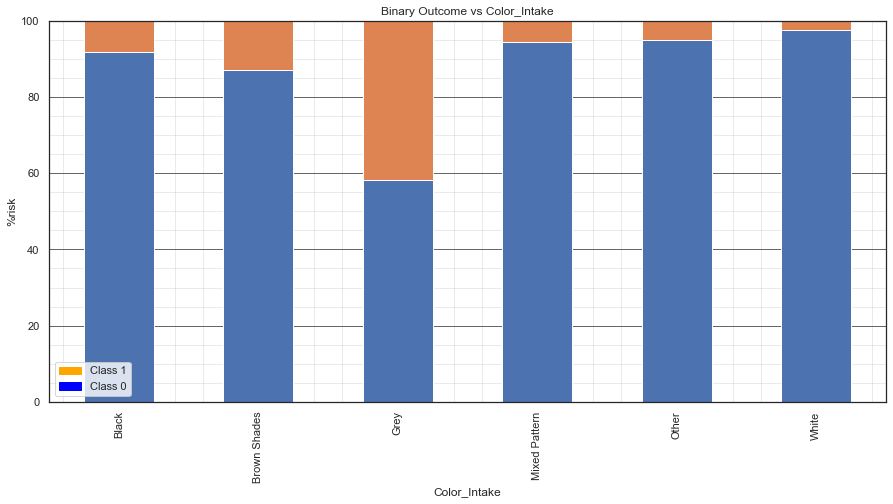

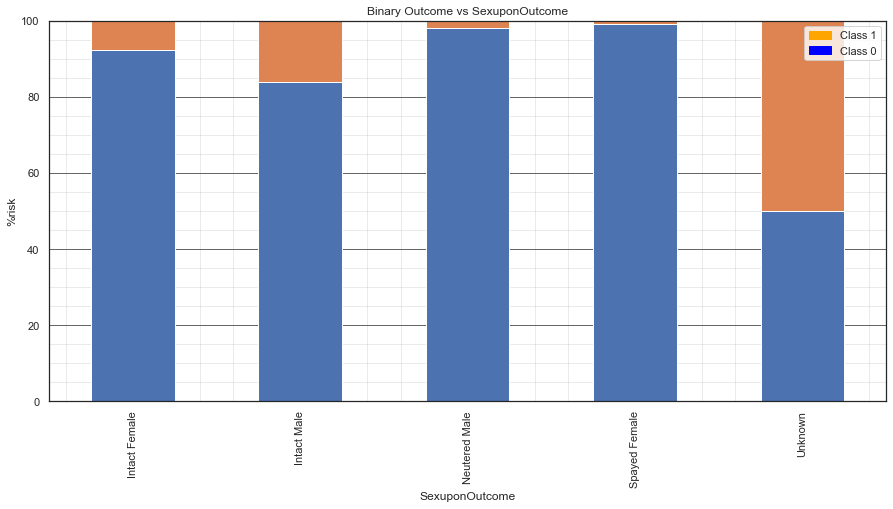

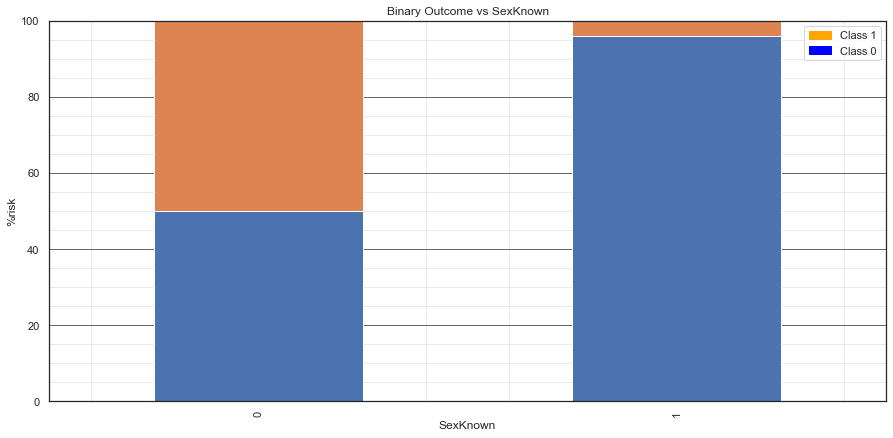

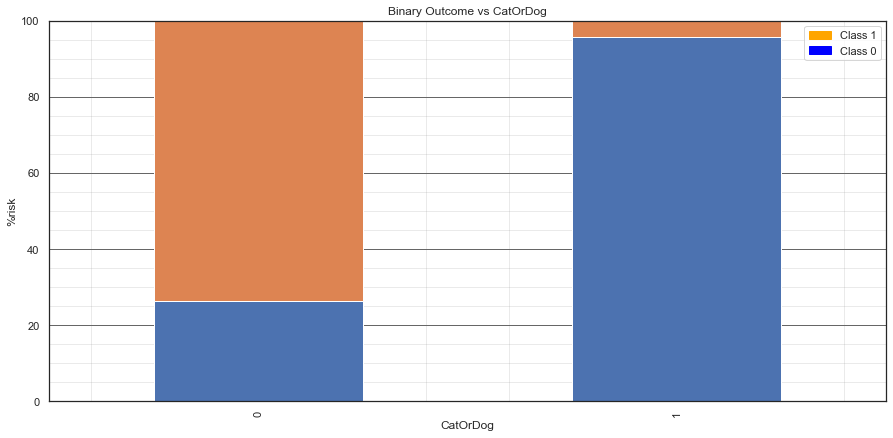

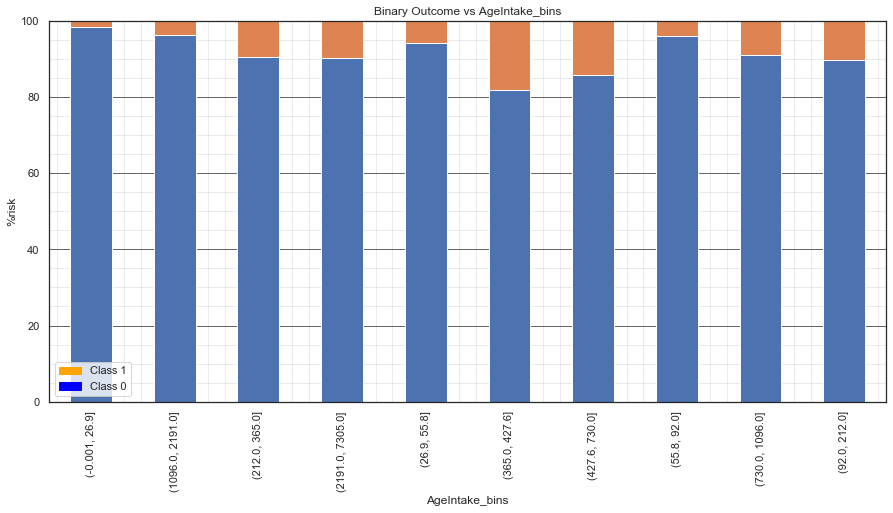

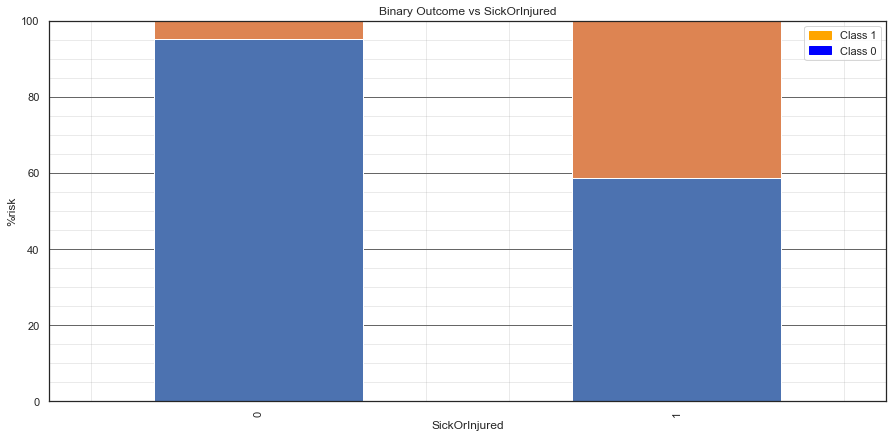

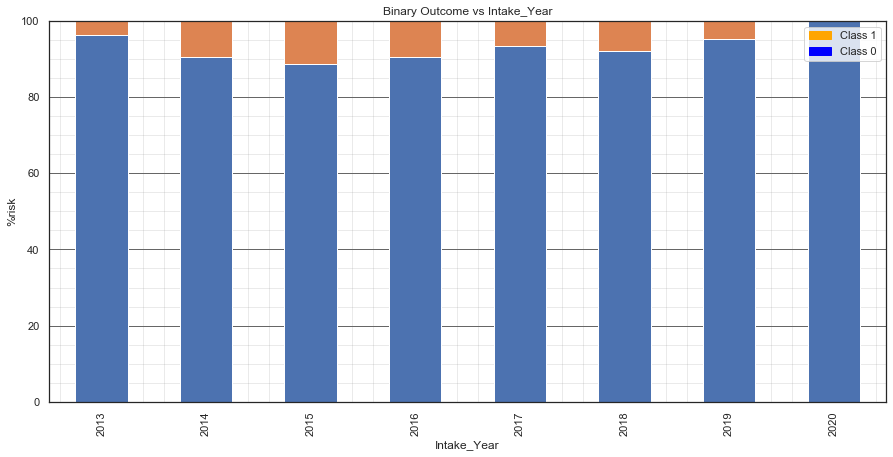

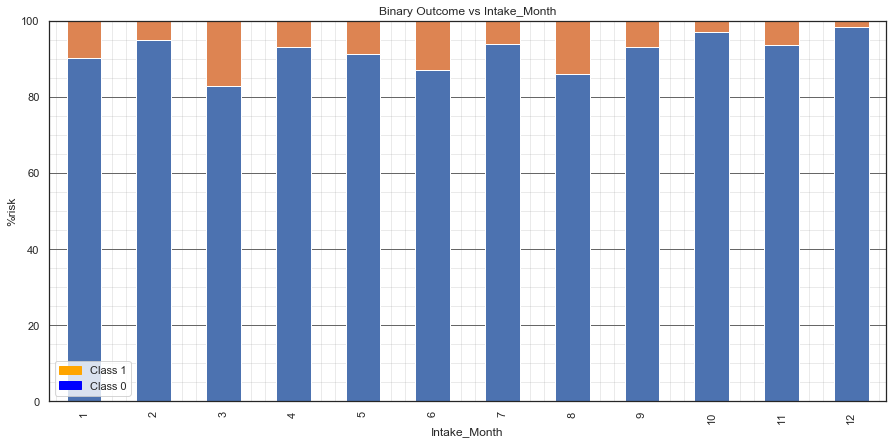

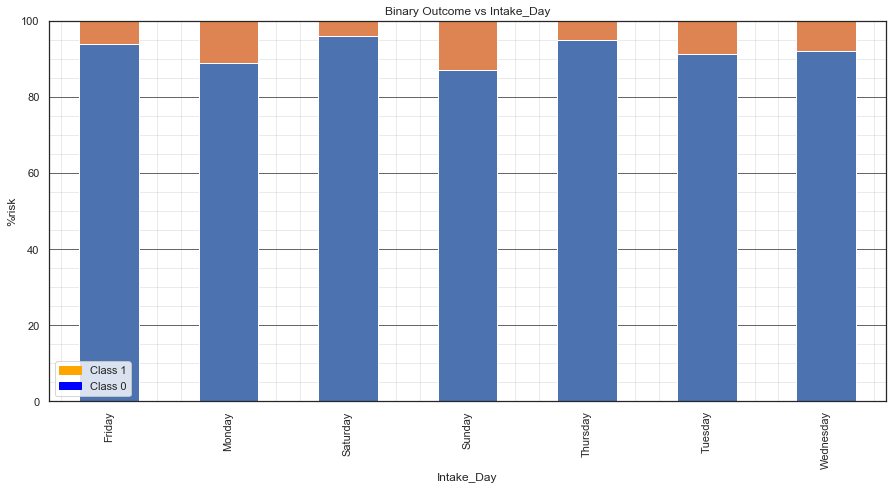

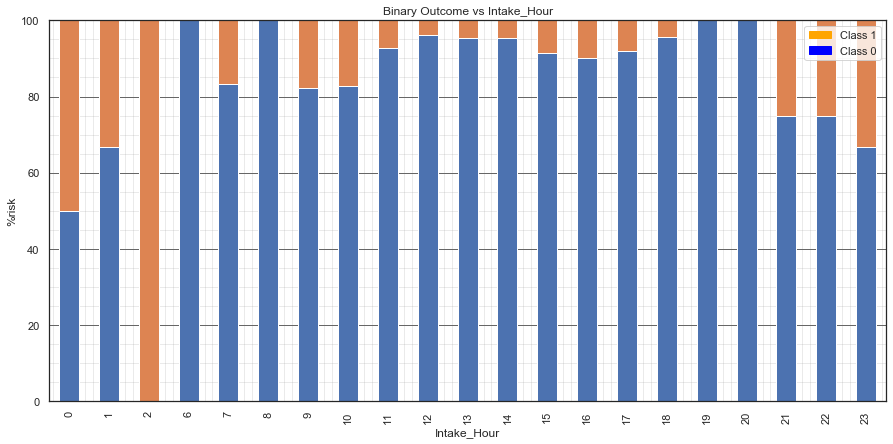

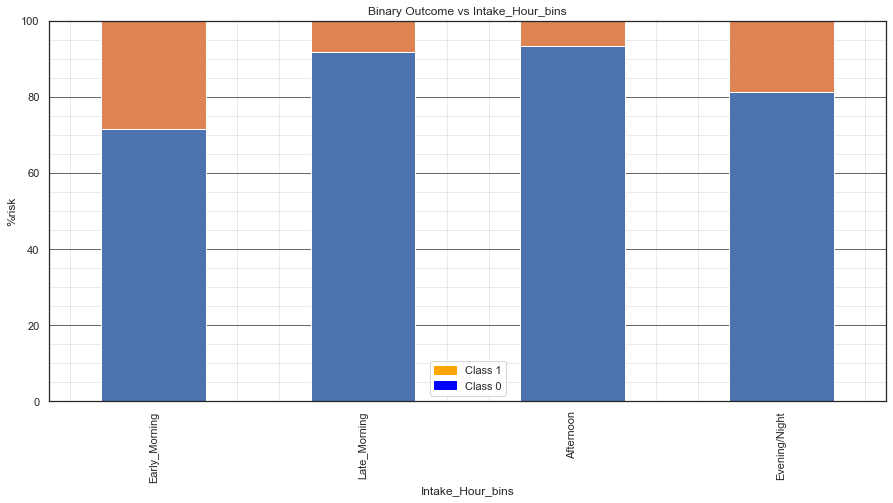

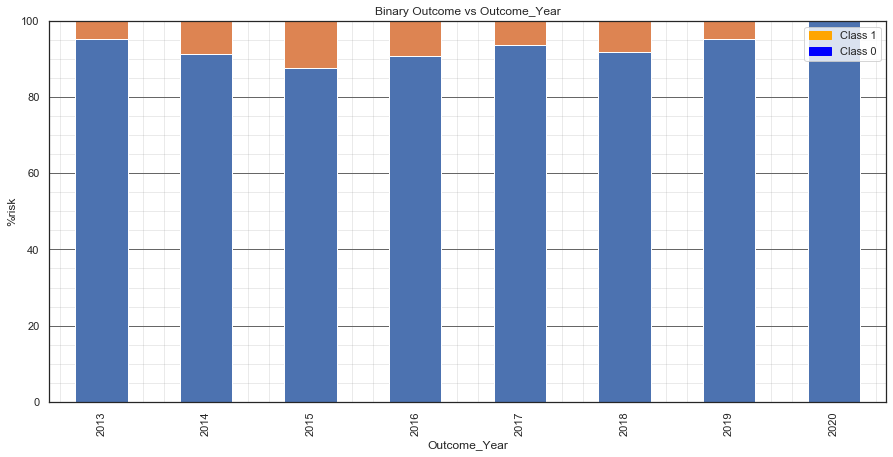

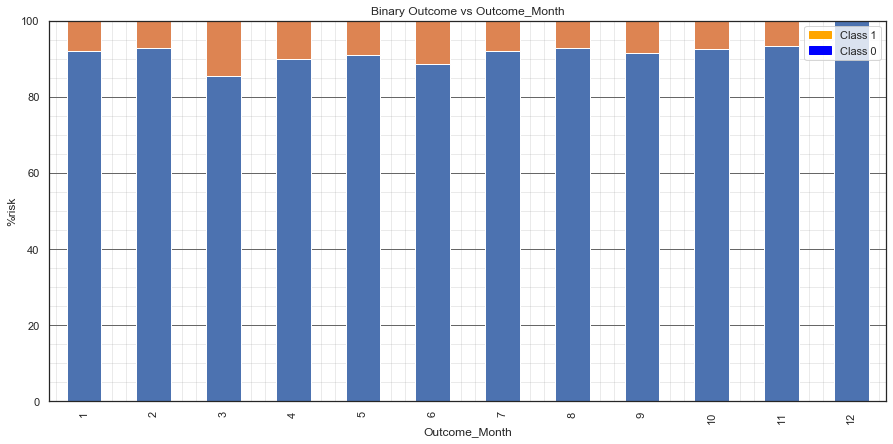

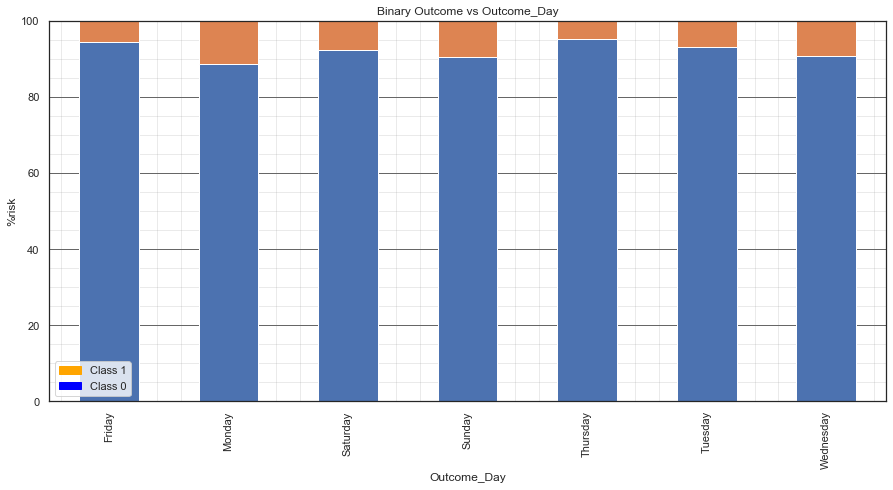

In [59]:
# X_train[categorical_features].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)


# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_features:
    # Using code from the module lab

    values = pd.unique(df_temp[categorical_feature].ravel())

    # create percent column and initalise to 0
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")

    # loop through each value in the feature col1
    for i in values:

        count = df_temp[df_temp[categorical_feature] == i].count()['binary_outcome']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'binary_outcome']].groupby([categorical_feature,'binary_outcome']).sum()

    #plot the results
    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"Binary Outcome vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Class 1')
    blue_patch = mpatches.Patch(color='blue', label='Class 0')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines to make the plots easier to visualise
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    my_plot.set_xlabel(categorical_feature)
    my_plot.set_ylabel("%risk")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

#### 1.2.4 Interpretation of the results

As we have a lot of categorical features, we will only give a brief discussion of each. 

- **Name_Provided**: We can see that animals with no name are 20% more likely to have a negative outcome. When looking at the absolute values we can see that in this training dataset 211 animals had no name and 489 animals had a name. 

- **FoundLocation**: We can see that if an animal is found in Austin, Del Valle, Pflugerville or Travis, they are 5-10% more likely to have a negative outcome than if found at the other locations. In fact, we see no negaitve outcome at any other locations. Upon examination of the counts however, we can see that this is most likely due to the cities mentioned having a much larger representation. 

- **Intake_Type**: We can see here that intake type has some interesting findings. As expected, all euthenasia requests result in a negative outcome. Interestingly, all animals with intake type *Wildlife* also have a negative outcome. Although the absolute value of animals with value *Wildlife* is lower than *Stray* and *Owner Surrender*, the value is not too low to be deemed promising. 

- **IntakeCondition**: Here we can see that if an animal is sick or injured, they are 40-50% more likely to have a negative outcome. Although when looking at the absolute values, we can see that the sick or injured animals only make up approximately 10% of the total, the graphs show that this feature still seems like a strong predictor.

- **AnimalType_Intake**: We see in this plot that animals of type *Bat* or *Other* are 100% and 45% more likely to have a negative outcome, respecitvely, than animals of type *Bird, Cat* or *Dog*. On further inspection of the value counts however, we can see that there are only 5 birds. Thus, it seems that animals of type *Cat* and *Dog* are most likely to have a positive outcome. 

- **SexUponIntake** and **SexUponOutcome**: In the graphs for both *SexUponIntake* and *SexUponOutcome* we can see that animals with a value of *Unknown* are 55% more likely to have a negative outcome. However, it also seems likely that the most predictive aspect of this feature is whether or not the sex is known. As discussed above, a new feature *SexKnown* has been created to capture this information. 

- **Breed_Intake**: We can see that breeds of other animals are more likely to have a negative outcome. This is unsurprising after analysing the *AnimalType_Intake* plot and seeing that cats and dogs are most likely to have a positive outcome. We also learn from this graph that *Pit Bull* and *Poodle* dogs are 10% and 12% more likely to have a negative outcome that most other dog breeds, respectively. Similarly, we can see that 22% of *Siamese* cats have a negative outcome. Surprisingly, there are no strong relationships between other dog breeds or any cat breeds and the binary outcome. It is possible that this is due to the difficultly of grouping the different values within this feature. Many different breed which had a low cardinality have been grouped into "Other" values. 

- **Color_Intake**: We can see that there are no strinkingly strong relationships between a color and the binary outcome. We can see however, that *Brown* has the worst outcome followed by *Grey/Silver* while *White* and *MixedPattern* animals are more likely to be adopted or returned to their owner. Most of these findings are unsurprising given our understanding of popular pet colours. 

**new features created in homework1**:
- **SexKnown**: We can see that if the sex of the animal is not known, there is a 50% higher likelihood of a negative outcome.
- **CatOrDog**: Observing this plot we can see that if an animal is not a cat or a dog they are 80% more likely to have a negative outcome. 
- **AgeIntake_bins**: We can see that there is no clear pattern between the age of intake bins and the binary outcome. It was expected that older animals would be more likely to have a negative outcome due to both a higher likelihood of death and a lower likelihood of being adopted. However, we can see that the greatest likelihood of a negative outcome is actually seen in the bin representing an age of 365-427 days. The likelihood of a negative outcome then decreases as the ages increase. 
- **SickOrInjured**: We can see from the plot that if an animal is sick or injured when entering the shelter, they are 35% more likely to have a negative outcome. 

**Year, Month, Day, and hour features**:

- **Intake_Year** and **Outcome_Year**: Observing the plots for these we see no clear relationship between the year and the binary outcome.
- **Intake_Month**: Similarly, observing the plots for both month of intake see no clear trend. We can see that for *Intake_Month*, March has the highest likelihood of a negative outcome. This is possibly due to it being shortly after Christmas, when people no longer want pets given as Christmas gifts. We can also see a slightly higher likelihood of a negative outcome in June and August. It could be assumed that this is because of animal breeding seasons, resulting in more strays entering the shelter. However, the likelihood of a negative outcome in May and July is lower and does not fit with this assumption. Overall there is no clear pattern. 
- **Outcome_Month**: For Outcome_Month, we can see again that March shows the highest likelihood of a negative outcome. However, overall there appears to be no strong relationship with the binary outcome. 
- **Intake_Day** and **Outcome_Day** In the plots for these we see some variation in the relationship with the binary outcome however, there is no clear trend. 
- **Intake_Hour** is interesting. It seems that there is a much higher likelihood of a negative outcome if the animal is taken into the shelter during the night, with intake at 2am having a 100% likelihood of a negative outcome. On further investigation we can see that the number of animals being dropped in at these times is very low compared to the daylight hours. However, after doing some research into the Austin Animal center, I have learned that the opening hours are 11am-7pm. This information increases the relevance of the results seen during the night, as it is expected that the animals will not have as good an outcome if found or left at the shelter outside opening hours. 
- **Intake_Hour_bins** As expected, the information in *Intake_Hour* is well represented in this feature. We can see that an animal that enters the shelter in the early morning (0-6am) has a 30% likelihood of being in class 1 and an animal entering the shelter in the evening/night (6pm-midnight) has a 20% likelihood of being in class 1. These findings are in comparison to the other two values which show a 5-10% likelihood of the animal being in class 1.

**PLOT DATE OF BIRTH HERE!**

In [60]:
# # dict to hold correlation values 
# corr_dict = {}

# # plot pairwise interaction between all continuous features and target
# # create temp df to merge column and target
# df_temp = pd.concat([X_train['DateofBirth'], y_train], axis=1)
# print("dftemp is: ", df_temp)
# # store correlation in variable
# correlation = df_temp[['DateofBirth', "binary_outcome"]].corr().values[0,1]
# # plot the column and tartget feature
# df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
# # add correlation to dict
# corr_dict[column] = correlation

# # dataframe holding sorted correlation values to aid in interpreting results
# corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['binary_outcome']).sort_values('binary_outcome', ascending=False)
# corr_df

In [61]:
low_information_gain_date_features = ['DateofBirth']

#### 1.2.5 Summary and drop features

From continuous vs target feature plots (1.2.1) we saw that neither of the two features *AgeUponIntake* or *AgeUponOutcome* showed a high correlation with the target feature. These features will be dropped. 
 
From categorical vs target feature (1.2.3) we saw that the following features did not show a clear relationship with the target feature and can be removed for now: 

    - FoundLocation
    - Intake_Year
    - Outcome_Year
    - Intake_Month
    - Outcome_Month
    - Intake_Day
    - Outcome_day
    - Intake_Hour
    - AgeIntake_bins

In addition, there are some categorical features which can be better represented by the new features created at the end of assignment 1. 
- Firstly, the only finding in *SexUponIntake* and *SexUponOutcome* which seems significant is whether or not the sex of the animal is known or not. 
    - We can see in *SexUponIntake* that animals with an unknown sex have a 45% likelihood of a negative outcome. 
    - Similary, in *SexUponOutcome* we can see that animals have a 50% likelihood of a negative outcome. 
    - As a result, it would seem that the features *SexUponIntake* and *SexUponOutcome* can be replaced with the feature *SexKnown*. However, upon further analysis we can see that whether or not an animal is neutered in the shelter in an important factor. Looking at the absolute values for *SexUponIntake* we can that there are 236 neutered males and 99 intact males. We can see there there is no clear variation between the outcome of neutered and intact males. However, in *SexUponOutcome* we can that the number of intact males has dropped to 81, presumably because many males got neutered while in the shelter. Despite the drop in the number of intact males, we can see a higher likelihood of a negative outcome - approximately 10% higher than at intake. As a result, we can assume that other values are important in these feature, not just whether or not the sex is know. 
    - Therefore, we will keep the oringinal two features and drop the new feature *SexKnown*. 
- Based on the discussion of *AnimalType_Intake* above, it is likely that the new feature *CatOrDog* can represent the relevant information in this feature. 
- Similary, based on the above findings and discussion regarding *IntakeCondition*, it is likely that the new feature *SickOrInjured* can provide the relevant information.

As a result, in addition to the features listed above, it appears that the following features can be removed: 

    - SexKnown
    - AnimalType_Intake
    - IntakeCondition

We will leave all other categorical features in for now. 

We have seen above that the feature *Intake_Hour* looks promising. However, as this feature has a high cardinality, we will now group it into bins. This will reduce the number of dummy features created later on. After grouping the values of this feature into bins, we will then compare it again to the binary outcome before making any decisions. 

We will now create a list of the low information categorical features listed above. 

In [62]:
low_information_gain_categorical_features = ['FoundLocation','Intake_Year', 'Outcome_Year', 'Intake_Month','Outcome_Month', 'SexKnown', 'AnimalType_Intake', 'IntakeCondition', 'AgeIntake_bins',  'Intake_Day', 'Outcome_Day', 'Intake_Hour']

We will now drop the low impact categorical features listed above. 

- Before dropping we will duplicate the original dataframe *df* and label the duplicate as *df_version1*
- We will drop features from the duplicate *df_version1* only.
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset *df_version1* with the original dataset *df*.


In [63]:
low_value_features = list(set(low_correlation_continuous_features + low_information_gain_categorical_features + low_information_gain_date_features))
# before dropping make copy of original
df_version1 = df.copy()
# drop low value features
df_version1.drop(low_value_features, 1, inplace=True)
print('\nRemaining columns:', df_version1.columns)
print('\nNew shape:', df_version1.shape)


Remaining columns: Index(['Name_Provided', 'IntakeType', 'SexuponIntake', 'Breed_Intake',
       'Color_Intake', 'SexuponOutcome', 'binary_outcome', 'CatOrDog',
       'SickOrInjured', 'Intake_Hour_bins'],
      dtype='object')

New shape: (1000, 10)


### 1.3 Prepare the dataset for modelling

Now we have picked our descriptive features for the whole dataset, we will now carry out a number of additional steps in order to prepare the dataset for modelling: 
- Convert the categorical variables into dummies variables so that they can be used for modelling.
- Remove the redundant dummies which contain no additional information.
- Set up up the train test split again based on the dataset with the dummies included.

We will now go through these steps in more detail. 

Firstly, as described in section 7.4.3 of the course textbook 'Fundamentals of Machine Learning for Predictive Data Analytics', the most common approach to handling categorical features in regression models is to use a transformation that converts a single cateogrical feature into a number of continuous features that can encode the levels of the categorical feature. The levels of the categorical feature are encoded by setting the value of the new continuous feature which corresponds to the level of the categorical feature to 1, and the other continious features to 0. This is known as *dummy encoding* and is the approoach we will now take. 

The downside of this approach however, is that it creates a lot of new features in the dataset. In other words, as we will see in the linear regression steps below, it creates many new weights for which optimal values must be found. For this reason we carry out the second step above - remove the redundant dummies which contain no additional information. For example, we can assume that a zero in all new features implies that the original cateogrical feature had the first value. We will add the parameter *drop_first = True* in the code below in order to execute this step. 

In [64]:
# set up dummies features
df_version1 = pd.get_dummies(df_version1, drop_first=True)

In [65]:
df_version1.head()

,binary_outcome,Name_Provided_Yes,IntakeType_Owner Surrender,IntakeType_Public Assist,IntakeType_Stray,IntakeType_Wildlife,SexuponIntake_Intact Male,SexuponIntake_Neutered Male,SexuponIntake_Spayed Female,SexuponIntake_Unknown,...,Color_Intake_White,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,CatOrDog_1,SickOrInjured_1,Intake_Hour_bins_Late_Morning,Intake_Hour_bins_Afternoon,Intake_Hour_bins_Evening/Night
0,0.0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,0.0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
2,0.0,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,0.0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
4,0.0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0


**The features are:**

As we are not keeping any of our continuous features for now, our features are comprised only of the uint types generated when making dummies above.

In [66]:
#put all features together into a variable
features = df_version1.select_dtypes(include=['uint8']).columns.tolist()
features

['Name_Provided_Yes',
 'IntakeType_Owner Surrender',
 'IntakeType_Public Assist',
 'IntakeType_Stray',
 'IntakeType_Wildlife',
 'SexuponIntake_Intact Male',
 'SexuponIntake_Neutered Male',
 'SexuponIntake_Spayed Female',
 'SexuponIntake_Unknown',
 'Breed_Intake_Boxer',
 'Breed_Intake_Chihuahua Shorthair',
 'Breed_Intake_Domestic Longhair',
 'Breed_Intake_Domestic Medium Hair',
 'Breed_Intake_Domestic Shorthair',
 'Breed_Intake_German Shepherd',
 'Breed_Intake_Labrador Retriever',
 'Breed_Intake_Miniature Poodle',
 'Breed_Intake_Other Animal Breeds',
 'Breed_Intake_Other Cat Breeds',
 'Breed_Intake_Other Dog Breeds',
 'Breed_Intake_Pit Bull',
 'Breed_Intake_Siamese',
 'Color_Intake_Brown Shades',
 'Color_Intake_Grey',
 'Color_Intake_Mixed Pattern',
 'Color_Intake_Other',
 'Color_Intake_White',
 'SexuponOutcome_Intact Male',
 'SexuponOutcome_Neutered Male',
 'SexuponOutcome_Spayed Female',
 'SexuponOutcome_Unknown',
 'CatOrDog_1',
 'SickOrInjured_1',
 'Intake_Hour_bins_Late_Morning',
 'I

### Train/test split
- We will now split the dataset into train/test subsets using the dummy values created above
- As explained in section 1.1 above, we will use stratified sampling. 
- The target *binary_outcome* is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [67]:
# y = pd.DataFrame(df["binary_outcome"])
y = df_version1['binary_outcome']
X = df_version1.drop(["binary_outcome"],1)

In [68]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1, stratify=y)

print("original range is: ",df_version1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

print("\nTarget feature ShoeSponsor total dataset counts:\n\n", y.value_counts())
print("\nTraining data ShoeSponsor counts:\n", y_train.value_counts())
print("\nTest data ShoeSponsor counts:\n", y_test.value_counts())

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000

Target feature ShoeSponsor total dataset counts:

 0.0    920
1.0     80
Name: binary_outcome, dtype: int64

Training data ShoeSponsor counts:
 0.0    644
1.0     56
Name: binary_outcome, dtype: int64

Test data ShoeSponsor counts:
 0.0    276
1.0     24
Name: binary_outcome, dtype: int64


We will now look at the first five lines of the training and test subsets. 

In [69]:
print("\nDescriptive features in X_train:\n", X_train.head(5))
print("\nTarget feature in y_train:\n", y_train.head(5))
print("\nDescriptive features in X_test:\n", X_test.head(5))
print("\nTarget feature in y_test:\n", y_test.head(5))


Descriptive features in X_train:
      Name_Provided_Yes  IntakeType_Owner Surrender  IntakeType_Public Assist  \
400                  0                           0                         0   
55                   1                           0                         0   
777                  0                           0                         0   
329                  1                           1                         0   
196                  1                           1                         0   

     IntakeType_Stray  IntakeType_Wildlife  SexuponIntake_Intact Male  \
400                 1                    0                          0   
55                  1                    0                          0   
777                 1                    0                          0   
329                 0                    0                          0   
196                 0                    0                          0   

     SexuponIntake_Neutered Male  SexuponInta

#### Reset the indexes of the training and test splits
- We can see from the output above that the indexes are no longer consecutive for any of the dataframes. 
- We will now deal with that next as it will have an effect when we merge the dataframes later in the assignment.

In [70]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,Name_Provided_Yes,IntakeType_Owner Surrender,IntakeType_Public Assist,IntakeType_Stray,IntakeType_Wildlife,SexuponIntake_Intact Male,SexuponIntake_Neutered Male,SexuponIntake_Spayed Female,SexuponIntake_Unknown,Breed_Intake_Boxer,...,Color_Intake_White,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,CatOrDog_1,SickOrInjured_1,Intake_Hour_bins_Late_Morning,Intake_Hour_bins_Afternoon,Intake_Hour_bins_Evening/Night
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1,1,0,0,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,1,0
4,1,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0


We are now ready to model the datasets.

## 2) Linear Regression

#### 2.1) On the training set, train a linear regression model to predict the target feature, using only the descriptive features selected in exercise (1) above.

In [71]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### (2.2) Print the coefficients learned by the model and discuss their role in the model.


In [72]:
#Print out the weights that have been learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['Name_Provided_Yes', 'IntakeType_Owner Surrender',
       'IntakeType_Public Assist', 'IntakeType_Stray', 'IntakeType_Wildlife',
       'SexuponIntake_Intact Male', 'SexuponIntake_Neutered Male',
       'SexuponIntake_Spayed Female', 'SexuponIntake_Unknown',
       'Breed_Intake_Boxer', 'Breed_Intake_Chihuahua Shorthair',
       'Breed_Intake_Domestic Longhair', 'Breed_Intake_Domestic Medium Hair',
       'Breed_Intake_Domestic Shorthair', 'Breed_Intake_German Shepherd',
       'Breed_Intake_Labrador Retriever', 'Breed_Intake_Miniature Poodle',
       'Breed_Intake_Other Animal Breeds', 'Breed_Intake_Other Cat Breeds',
       'Breed_Intake_Other Dog Breeds', 'Breed_Intake_Pit Bull',
       'Breed_Intake_Siamese', 'Color_Intake_Brown Shades',
       'Color_Intake_Grey', 'Color_Intake_Mixed Pattern', 'Color_Intake_Other',
       'Color_Intake_White', 'SexuponOutcome_Intact Male',
       'SexuponOutcome_Neutered Male', 'SexuponOutcome_Spayed Female',
       'Sexupo

#### Discussion: 

Before discussing the weights printout out above, we will first introduce linear regression. 

- Linear regression is a supervised machine learning method which is used to make predictions based on linear relationship between the target (dependent variable) and any number of independent variables (also known as predictors).
- It finds the line of best fit that describes the relationship between the target and predictors. 
- The linear regression formula takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
    
- In the formula, w_0, w_1 etc are known as the **model coefficients**. 
- To create the predictive model using linear regression, these coefficients must be "learned". 
- As seen in the image below, this is usually done using the **least squares criterion**. In other words, we find the line of best fit that describes the relationship between the target and predictors which minimises the **sum of squared residuals** (also known as sum of squared errors).
<br><img src="linear_regression.png" style="width: 300px;"/> <br>
Source: https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb

- We will now understand the image above: 
    - The **black** dots are the observed values of x and y.
    - The **blue line** is the least squares line. 
    - The **red lines** are the residuals. These are the distances between the observed values and the least squares line.
    
- Linear regression is a regression task, which means that it predicts a numeric target feature. Thus, the output from the formula above is a continuous value that can be less than 0 and higher than 1.
- It is important to note one of the downfalls of linear regression is that it is sensitive to outliers. 

**Discussing the coefficients learned by the model:**
- We can see above that the intercept is 1.15(this is w_0). This is the value of y when x is zero. In other words it is where the model intercepts the x axis. 
- If all other coefficients were zero, the model result would be 1.15
- We can see the coefficients for each feature above. They are zipped together in a single list for ease of visualisation and interpretation.
- All of our features are categorical features which are dummy coded. Thus, care needs to be taken when interpreting the coefficients. The first value of each feature (which we have dropped) is the reference and each dummy is compared to the reference.
- For example, we see that Name_Provided_Yes decreases by 0.074%. This makes sense as we saw in our barplot above that animals with no name are more likely to be in class 1.

**Classification problem**
- We are trying to solve a classification problem and thus it is important to note that the output from a linear regression model is not suited to this type of problem.
- The output we get from linear regression is not a probability. As a result, we will need to perform a thresholding step in order to convert the output into a binary classification. 
- The threshold will be as follows: 
    - Any values >= 0.5 will be cast to 1
    - Any values <0.5 will be cast to 0

#### 2.4 Printing 100 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples. 
- As discussed above, we will now threshold the predicted target feature value given by the linear regression model at 0.5. This will give us the predicted class. 

In [73]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(20))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0              0.0        0.0
1              0.0        0.0
2              0.0        0.0
3              0.0        0.0
4              0.0        0.0
5              1.0        0.0
6              0.0        0.0
7              0.0        0.0
8              0.0        0.0
9              0.0        0.0
10             0.0        0.0
11             0.0        0.0
12             0.0        0.0
13             0.0        0.0
14             0.0        0.0
15             0.0        0.0
16             1.0        1.0
17             0.0        0.0
18             0.0        0.0
19             0.0        0.0


#### 2.5 Evaluation metrics based on training data
- We will now print the classification evaluation measures computed on the training set. These are:
    - Accuracy
    - Precision
    - Confusion Matrix
    - Recall
    - F1
- We will then discuss our findings.

In [74]:
#print evaluation measures
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9528571428571428
Confusion matrix: 
 [[643   1]
 [ 32  24]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       644
         1.0       0.96      0.43      0.59        56

    accuracy                           0.95       700
   macro avg       0.96      0.71      0.78       700
weighted avg       0.95      0.95      0.94       700



#### Interpretation of results

We will now explain what each of the measures above means and will discuss our results. 

- **Accuracy** tell us how often the model is correct. 
    - We have an accuracy of 95%
- **Confusion Matrix** tells us the following:
    - [0][0] TRUE NEGATIVE - The number predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number predicted 1 that is actually 1
    - We can see that we have 32 false negatives.
- **Precision** tells us the following"
    - What percentage of the predicted positive values are actually positive
    - How good the model is at predicting the positive class
    - It is the number of values which were correctly predicted positive over the total number of positive values
    - Our precision negative is 0.95
    - Our precision positive is 0.96
- **Recall** tells us what % of the positive values we succesfully predicted.
    - It is the number of values which were correctly predicted positive over the total number of positive values. 
    - Our recall negative is 1.00
    - Our recall positive is 0.43. This low result is due to the large number of false negatives mentioned above. 
- **F1 Score** is a weighted average of precision and recall. 
    - Our F1 score negative is 0.97.
    - Our F1 score positive is 0.59.
    
**Summary**
- Some of the results are quite good. However, the positive recall is quite low.
- We can see that the model is better at predicting the negative class. 
- The makes sense as the model has more negative data to learn from as it is the majority class. 

#### 2.6 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

In [75]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(20))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0              0.0        0.0
1              0.0        0.0
2              0.0        0.0
3              0.0        0.0
4              0.0        0.0
5              0.0        0.0
6              0.0        0.0
7              1.0        0.0
8              1.0        1.0
9              0.0        0.0
10             0.0        0.0
11             0.0        0.0
12             0.0        0.0
13             0.0        0.0
14             0.0        0.0
15             0.0        0.0
16             0.0        0.0
17             0.0        0.0
18             0.0        0.0
19             0.0        0.0


##### Evaluation metrics based on test data

In [76]:
# print evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9566666666666667
Confusion matrix: 
 [[276   0]
 [ 13  11]]
Classification report - Test data:
                precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       276
         1.0       1.00      0.46      0.63        24

    accuracy                           0.96       300
   macro avg       0.98      0.73      0.80       300
weighted avg       0.96      0.96      0.95       300


==================== Train Data ======================
Accuracy:  0.9528571428571428
Confusion matrix: 
 [[643   1]
 [ 32  24]]

Classification report: - Training data
                precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       644
         1.0       0.96      0.43      0.59        56

    accuracy                           0.95       700
   macro avg       0.96      0.71      0.78       700
weighted avg       0.95      0.95      0.94       700



#### Interpretation of results and comparison with training set

We will now compare the test and training results.
- **Accuracy:** 
    - The accuracy of the test data is marginally higher than the training data with a value of 95.66% compared to 95.25%. 
- **Precision:** 
    - The precision score for predicting the negative class has increased from 95% to 96%.
    - The precision score for predicting the positive class has increased from 96% to 100%
- **Recall:**
    - The recall score for predicting the negative class is the same at 100%
    - The recall score for predicting the positive class has increased from 43% t0 46%.
- **F1:**
    - The f1 score for predicting the negative class has increased from 97% to 98%.
    - The f1 score for predicting the positive class has increased from 59% to 63%.

**Summary**
- We are pleased with these results as we are now testing the predictive model on data that has not been seen before. This is a good sign that the model is generalising to new data. 
- We will now explore this even further using cross validation. 

#### 2.7 Cross-validation

- We will now perform cross-validation on the linear regression model. 
- Using cross validation we do repeated train/test splits and average the error on the test datasets. Thus, it can result in a less biased result than a simple train/test split. 
- To perform cross-validation we will randomly split the dataset into 10 equal partitions. We will then use one partition as the test set and the union of all other partitions as the training set. We will evaluate the results of the test set. We will then repeat these steps using a different partition as the test set for each iteration. Finally, we will take the average of all results. 

We will begin by creating a function to perform cross-validation as this is not provided by Scikit-Learn.

In [77]:
#this code is from the sample solution provided
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function which will perform 100 fold cross validation and store results in a dataframe. This will done in order simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [78]:
#this code is from the sample solution provided
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

In [79]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 100 fold cross validation are:")
linRegDF

Mean results from 100 fold cross validation are:


,Linear_Regression
accuracy,0.950333
precision,0.939904
recall,0.461117
f1,0.590939


As we can see, the results are marginally lower than we saw above for the test sample. For example, recall for the test sample was 0.46 in comparison to 0.43 seen here. This is due to the fact that we have taken the mean of 100 sets of results. 

## (3) Logistic Regression   

#### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above.

We will now use the same feature set selected above to perform a logistic regression. We then be able to compare the results to the linear regression performed above. 

In [80]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

In [81]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['Name_Provided_Yes', 'IntakeType_Owner Surrender',
       'IntakeType_Public Assist', 'IntakeType_Stray', 'IntakeType_Wildlife',
       'SexuponIntake_Intact Male', 'SexuponIntake_Neutered Male',
       'SexuponIntake_Spayed Female', 'SexuponIntake_Unknown',
       'Breed_Intake_Boxer', 'Breed_Intake_Chihuahua Shorthair',
       'Breed_Intake_Domestic Longhair', 'Breed_Intake_Domestic Medium Hair',
       'Breed_Intake_Domestic Shorthair', 'Breed_Intake_German Shepherd',
       'Breed_Intake_Labrador Retriever', 'Breed_Intake_Miniature Poodle',
       'Breed_Intake_Other Animal Breeds', 'Breed_Intake_Other Cat Breeds',
       'Breed_Intake_Other Dog Breeds', 'Breed_Intake_Pit Bull',
       'Breed_Intake_Siamese', 'Color_Intake_Brown Shades',
       'Color_Intake_Grey', 'Color_Intake_Mixed Pattern', 'Color_Intake_Other',
       'Color_Intake_White', 'SexuponOutcome_Intact Male',
       'SexuponOutcome_Neutered Male', 'SexuponOutcome_Spayed Female',
       'Sexupo

#### Interpretation of results

Before discussing the coefficients printed above, we will first briefly introduce logistic regression. 

- As with linear regression, in logistic regression we find the line of best fit. 
- However, we have seen above that the output of linear regression in a continious value and is not a probability. Instead, we manually thresholded the value in order to convert it into a binary classification.
- In logistic regression however, the output is a probability between 0 and 1.
- Briefly, the logistic function involves the following steps: 
    - The line of best fit is found
    - The equation of the line is passed through a function called the sigmoid function.
    - The sigmoid function outputs a probability between 0 and 1.
    - The model then applies a threshold to the probability. Values < 0.5 are cast to 0 and values >= 0.5 are cast to 1. The threshold can be manually adjusted. 
    
- The formula for the logistic regression function is: 
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

**Discussing the coefficients learned by the model:**
- We can see above that the intercept is -0.128(this is w_0). This is the value of y when x is zero. In other words it is where the model intercepts the x axis. 
- If all other coefficients were zero, the model result would be -0.128.
- We can see the coefficients for each feature above. They are zipped together in a single list for ease of visualisation and interpretation.
- As explained above when discussing the coefficients learned for linear regression, the value of each dummy is in relation to the reference value for that feature.  
- The effect of each of these value 'x' is the same as for linear regression. When the value 'x' is fed into the logistic function we will see the difference between the two methods. 
- We mentioned above that linear regression is sensitive to outliers. Logistic regression on the other hand is good at dealing with outliers.

## TODO more info on logistic regression outliers. Add an image

#### 3.4 Printing 100 predicted target features and evaluate the prediction
- We will now print the predicted target feature value for the first 100 training samples. 

In [82]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(100))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0              0.0        0.0
1              0.0        0.0
2              0.0        0.0
3              0.0        0.0
4              0.0        0.0
..             ...        ...
95             0.0        0.0
96             0.0        0.0
97             1.0        0.0
98             0.0        1.0
99             0.0        0.0

[100 rows x 2 columns]


#### 3.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [83]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9614285714285714
Confusion matrix: 
 [[640   4]
 [ 23  33]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       644
         1.0       0.89      0.59      0.71        56

    accuracy                           0.96       700
   macro avg       0.93      0.79      0.84       700
weighted avg       0.96      0.96      0.96       700



#### Interpretation of results

- As before, the **Confusion Matrix** tells us the following:
    - [0][0] TRUE NEGATIVE - The number predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number predicted 1 that is actually 1
    - We can see that we have 23 false negatives and 3 false positives.
- **Accuracy:** 
    - We have an accuracy of 96%
- **Precision:**
    - Precision negative is 0.97
    - Precision positive is 0.93
- **Recall:**
    - Recall negative is 1.00
    - Recall positive is 0.54
- **F1 score:**
    - F1 negative is 0.98
    - F1 positive is 0.68

Summary: 
- Given the results we acheived for our linear regression, these results seem reasonable.
- The accuracy is in line with the 95% acheived for linear regression.
- We can see that logistic regression has better scores for recall and f1 for the positive class than seen in linear regression.

#### 3.6 Evaluate the model using the hold-out (30% examples) test set
- We will now evaluate the model using the test set. 
- We will compare the results of the test set against the training set. 
- We will then compare the results to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset)

We will begin by printing the actual binary_outcome vs the predicted values based on the test data. 

In [84]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0              0.0        0.0
1              0.0        0.0
2              0.0        0.0
3              0.0        0.0
4              0.0        0.0
5              0.0        0.0
6              0.0        0.0
7              1.0        1.0
8              1.0        1.0
9              0.0        0.0
10             0.0        0.0
11             0.0        0.0
12             0.0        0.0
13             0.0        0.0
14             0.0        0.0
15             0.0        0.0
16             0.0        0.0
17             0.0        0.0
18             0.0        0.0
19             0.0        0.0


In [85]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.96
Confusion matrix: 
 [[273   3]
 [  9  15]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       276
         1.0       0.83      0.62      0.71        24

    accuracy                           0.96       300
   macro avg       0.90      0.81      0.85       300
weighted avg       0.96      0.96      0.96       300

==================== Train Data =======================
Accuracy:  0.9614285714285714
Confusion matrix: 
 [[640   4]
 [ 23  33]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       644
         1.0       0.89      0.59      0.71        56

    accuracy                           0.96       700
   macro avg       0.93      0.79      0.84       700
weighted avg       0.96      0.96      0.96       700



#### Interpretation of results and comparison with training set

We will now compare the test and training results.
- **Accuracy:** 
    - The accuracy of the test data very similar to the training set at 96%.
- **Precision:** 
    - The precision score for predicting the negative class has stayed at 97%.
    - The precision score for predicting the positive class has decreased from 92% to 83%. 
- **Recall:**
    - The recall score for predicting the negative class has decreased from 100% to 99%.
    - The recall score for predicting the positive class has increased from 59% to 62%.
- **F1:**
    - The f1 score for predicting the negative class has remained the same at 98%.
    - The f1 score for predicting the positive class has decreased from 72% to 71%.

**Summary**
- We can see that the results of the test set for logistic regression have not improved from the training set to the same extent that we saw in linear regression.
- The precision for predicting the positive class has dropped. However, this is normal as we are testing the model on data it has not seen before. 
- The recall for the positive class has increased which is good. This shows that the model is generalising well to new data. 
- We will now investigate further with cross-validation. 

#### 3.7 Cross validation

- We will now perform cross-validation, as explained above in section 2.7.
- The first step we will take when performing cross-validation is to create a function which will perform 10 fold cross validation. This function will store the results into a dataframe. This step is taken in order to make it easier for us to evaluate the model by looking at accuracy, precision, recall, f1.
- Unlike for linear regression, Scikit-Learn has a built in function called cross_val_score() which we will use to calculate the results of the cross-validation. 

## TODO look at stdev also

In [86]:
#method is from sample solution provided
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()

    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

In the cell below we will now call the function defined above and summarise the results. 

In [87]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.958000
precision,0.893333
recall,0.550000
f1,0.668157


These results are in line with the results seen for cross-validation in section 2.7. We can see that the results for recall and f1 are lower than seen in the test set. The results for precision however, are higher at 92% compared to 83% in the test set. The accuracy is very similar at 95%. These results make sense given that we have taken the mean of 10 sets of results. 

## (4) Random Forest Model

- We will now train a random forest model on our data.
- As we are working on a classification problem, we will use classification trees. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated. This means that any ties between features will be split in the same way each time we run the code, thus giving us the same tree each time.

In [88]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above.
- A random forest model will now be trained on our test data.
- A random forest is an ensemble of decision trees.
- **Decision Tree:**
    - A decision tree is a chart that shows probabilities. It is a set of if-then-else rules computed from the training data and then used to classify the test data. 
    - It begins at the top of the tree and splits the features based on the information gain. As default, Scikit-Learn measures this using the Gini index.
        - As described at https://github.com/justmarkham/DAT4/blob/master/notebooks/15_decision_trees.ipynb, the gini index is a measure of total variance across classes in a region.
        - A dataset containing only one class will have 0 Gini impurity. 
        - The idea when building a decision tree is to choose the feature with the least Gini impurity as the root node. 
     - Thus, the tree will always split on the feature that gives the highest information gain. The feature with the highest information gain (lowest Gini impurity) will sit at the root of each decision tree.
    - We keep repeating this process until a stopping criteria is met (such as a **maximum depth of the tree** or the **minimum number of samples in the leaf**).
    - The farthest branch on the tree represents the end result.
- **Random Forest:**
    - A random forest is made up of a number of decision trees. 
    - The output of the random forest is based on the majority output of all combined decision trees. 


####  4.2.1  Train Decision tree
We will train 2 decision trees, with the same data.
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must stop splitting. 

In [89]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')
Max depth 10: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')


####  4.2.2  Display Decision tree
We will create graph of each tree and store as an image

In [90]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

<img src="DecisionTree4.png">

<img src="DecisionTree10.png">

In [91]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
4,IntakeType_Wildlife,0.134086
32,SickOrInjured_1,0.123591
17,Breed_Intake_Other Animal Breeds,0.084027
31,CatOrDog_1,0.082568
30,SexuponOutcome_Unknown,0.068871
0,Name_Provided_Yes,0.053216
3,IntakeType_Stray,0.048188
8,SexuponIntake_Unknown,0.039789
1,IntakeType_Owner Surrender,0.029569
22,Color_Intake_Brown Shades,0.028786


### 4.4 Printing 100 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 100 training examples. 

In [92]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
95,0.0,0.0
96,0.0,0.0
97,1.0,0.0
98,0.0,0.0


### 4.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [93]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9885714285714285
Confusion matrix: 
 [[644   0]
 [  8  48]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       644
         1.0       1.00      0.86      0.92        56

    accuracy                           0.99       700
   macro avg       0.99      0.93      0.96       700
weighted avg       0.99      0.99      0.99       700



### 4.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [94]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,1.0,0.0
8,1.0,1.0
9,0.0,0.0


In [95]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9566666666666667
Confusion matrix: 
 [[274   2]
 [ 11  13]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       276
         1.0       0.87      0.54      0.67        24

    accuracy                           0.96       300
   macro avg       0.91      0.77      0.82       300
weighted avg       0.95      0.96      0.95       300

==================== Train Data =======================
Accuracy:  0.9885714285714285
Confusion matrix: 
 [[644   0]
 [  8  48]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       644
         1.0       1.00      0.86      0.92        56

    accuracy                           0.99       700
   macro avg       0.99      0.93      0.96       700
weighted avg       0.99      0.99      0.99       700



### 4.7 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [96]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

In [97]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.952000
precision,0.846905
recall,0.525000
f1,0.621984
